# Introduction

One problem we can have when dealing with categorical target is to have one category that represents over 90%. Maybe you are wondering why is this a problem? Imagine we are using accuracy as a metric, a model that just put every sample in the biggest category will always yield a 90% accuracy even though the model is not learning. 

In a nutshell, what can we do?
- Check if our data is indeed imbalanced
- Don't use score as a metric try using F1-score
- Use confusion matrix to check weather the model is even trying to predict the small categories
- Try oversampling or undersampling . 

Some nice reference:

- https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
- https://www.youtube.com/watch?v=iTxzRVLoTQ0&ab_channel=StatQuestwithJoshStarmer

In [1]:
# import 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# This Libraries were use in the other example because we needed to predict a numerical value
# now we are predicting a category

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# New libraries that we haven't use yet!
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# These functions are going to be use in the next notebook
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import scikitplot as skplt


# Let us have a clearer code
from utils import cleaning_data

In [9]:
import plotly.io as pio
import plotly.express as px

pio.renderers.default = "svg"

import os

**Quick words the following dataset are data relating to transaction of creditcards. The minory group are fraud transaction and the big group are the "normal transaction".**

In [2]:
# Here is the data: https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/input

X_full = pd.read_csv('creditcard.csv')

# This is the real test, but we are going to use a test created by us to use easily ROC-AUC

# X_test_full = pd.read_csv('test.csv', index_col='PassengerId')

# Transported is the target, if there is no target eliminate row associated with it
column_to_predict = "Class"
X_full.dropna(axis=0, subset=[column_to_predict], inplace=True)
y = X_full[column_to_predict]
X = X_full.copy()
X.drop([column_to_predict], axis=1, inplace=True)

all_columns = X.columns


In [3]:
X_full.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [34]:
def is_imba(y):
    df = pd.DataFrame({'categories':list(y.value_counts().index),
                    'counts':list(y.value_counts().values)})
    percentage_biggest_class = (df['counts'].max()/df['counts'].sum())*100
    
    print(f"the biggest class has a {round(percentage_biggest_class,2)}% of all the samples in this dataset")
    fig = px.pie(df, values='counts', names='categories', title='Categories in the target values')
    fig.show()
    if percentage_biggest_class>90:
        return print("This class is clearly imbalanced")
    else: 
        return print("This class doesn't look like imbalanced, please make sure looking the graph")
    

the biggest class has a 99.83% of all the samples in this dataset


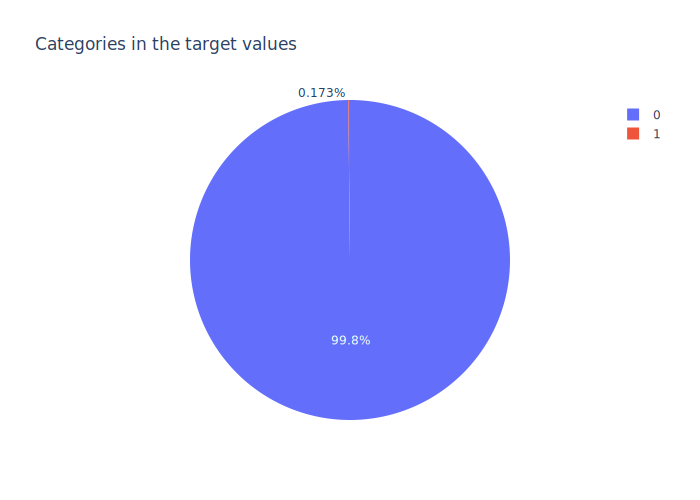

this class is clearly imbalanced


In [35]:
is_imba(y)

# Creating a WRONG MODEL 

Here we will create a wrong model without using any of the techniques for imbalanced dataset to see what we will get.

So this will be the naive approach, 

**please noticed this model is created intensionally in a bad way to ilustrate the importance of the methods we are going to use later!** 


In [38]:
# we do not have null!!
# X.isnull().any()

In [45]:
# All variables are number!! 
# X.dtypes

Notice we could clean a little our code because we do not have categories nor null values, but we are going to continue use our trusty pipeline. 

In [47]:
# notice we use stratify
X, X_test, y, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                random_state=0,stratify=y)  

In [48]:
def fix_model(X,y,X_test=False,
             cv=3,n_jobs=-1,scoring='accuracy',
             max_depth=10,n_estimators=344,n_neighbors=5,thr=0.5 ):

    # We are gonna use a cross validation now
    
    """
    best model so far is: 
    {'model__max_depth': 10,
    'model__n_estimators': 344,
    'preprocessor__numerical_transformer__imputer__n_neighbors': 5}
    
    
    """

    
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    numerical_col_imputed = [col for col in numerical_col if X[col].isnull().any()==True]

    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    categorical_col_imputed = [col for col in categorical_col if X[col].isnull().any()==True]
    # n_neighbors = an integer. KNNImputer 
    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", KNNImputer(n_neighbors=n_neighbors))
          ]
    )

    categorical_transformer =  Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col_imputed),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    # Define model
    model = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators ,random_state=0,n_jobs=n_jobs)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])
    # this "just" give me the score
    scores =  cross_val_score(pipe, X, y,cv=cv,scoring=scoring)
    
    # this fit the pipeline to a specific model, giving an specific traning set (notice that the cross-val does not do that)
    pipe.fit(X,y)
    y_proba = None
    try:
        # X_test = False this will not run and it is ok
        y_proba = pipe.predict_proba(X_test)
    except:
        pass
    
    return scores, y_proba

In [49]:
# What we got so far is
scores, y_proba = fix_model(X,y,X_test=X_test)

In [50]:
def plot_confusion_matrix(y_proba,y_test,thr=0.5):
    y_pred = (y_proba[:, 1] >= thr).astype(int)
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    acurracy = accuracy_score(y_test, y_pred)
    return print(f"acurracy : {round(acurracy,3)*100}% "),skplt.metrics.plot_confusion_matrix(y_test, y_pred)

acurracy : 99.9% 


(None,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>)

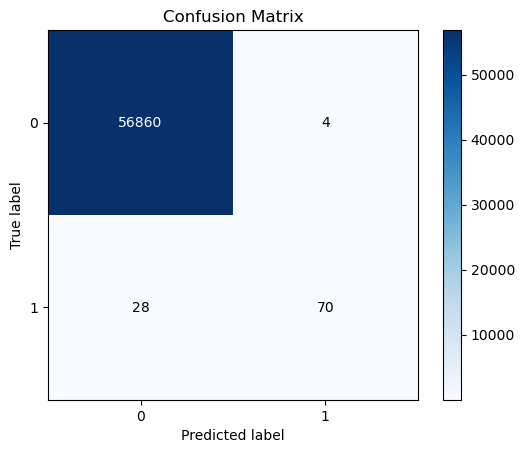

In [51]:
# Over 0.5 we have positive and below negative, a pretty normal way to do it!
plot_confusion_matrix(y_proba,y_test,thr=0.5)

I must admit, we did a better job that I was expencting without changing much of our trusty pipeline. We misclassified 28 element, that is to say, we coudn't identify 28 fraud of 98. But can we do even better? (notice we can also play with the threshold a little, let us play one time to see what we get)

acurracy : 99.9% 


(None,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>)

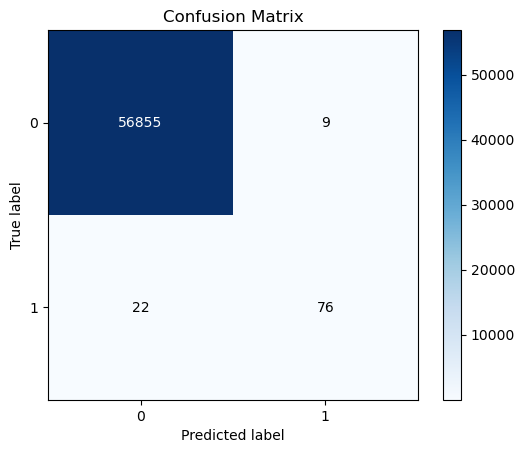

In [54]:
plot_confusion_matrix(y_proba,y_test,thr=0.3)

We could improve a tiny tad the results but can we improve even more using the cool techniques that we describe in the introduction? 

The problem with this model that we are only detecting a little more than a 1/3 of frauds.
